In [ ]:
import re
import string
import unicodedata
import warnings
from collections import Counter

import gensim.corpora as corpora
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim import corpora
from gensim.models import LdaModel

warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, get_single_color_func



In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [4]:
df = pd.read_csv('../data/2_silver/reviews_cleaned.csv')
df

reviewer     date original_language  \
0                    m555  2025-07           English   
1             Joan Rangel  2025-07           Spanish   
2                  juvo92  2025-07             Dutch   
3                      LC  2025-07            French   
4        jutta henckaerts  2025-07             Dutch   
...                   ...      ...               ...   
1825      Line VAN DOOREN  2014-07             Dutch   
1826   Irene von Birgelen  2013-07             Dutch   
1827          Sofie L'Eau  2013-07             Dutch   
1828  Robertina Van Damme  2013-07             Dutch   
1829           Sonny Ardi  2012-07           English   

                                                content      hospital  
0     I had an ivf consultation with a female Prof. ...    UZ Brussel  
1                  Excellent hospital!! I recommend it.    UZ Brussel  
2     Friendly doctors and nurses. I don't really un...    UZ Brussel  
3     I went to UZ Brussel in 2020 for egg cryoprese...    UZ Brussel  
4     The emergency department is horrible. If there...    UZ Brussel  
...                                                 ...           ...  
1825                            good connection top Uza  UZ Antwerpen  
1826  Thanks to the UZA, we have already added 5 yea...  UZ Antwerpen  
1827  Incompetent nurses and an ombudsman service wh...  UZ Antwerpen  
1828                Be pampered again by Frank kine :-)  UZ Antwerpen  
1829       You can take speculos for free and drink tea  UZ Antwerpen  

[1830 rows x 5 columns]

## Word Cloud

In [19]:
stop_words = set(stopwords.words('english'))

custom_stopwords_wordcloud = set(sorted([
    'also', 'already', 'always', 'antwerp', 'antwerpen', 'appointment', 'ask', 'asked', 
    'belgium', 'best', 'brussel', 'brussels', 'call', 'called', 'came', 'come', 'consultation', 
    'day', 'department', 'didnt', 'doctor', 'doctors', 'dont', 'dr', 'emergency', 'even', 'everything', 
    'experience', 'gasthuisberg', 'gent', 'ghent', 'go', 'good', 'heilig hart', 'hospital', 
    'hospitals', 'leuven', 'nurse', 'nurses', 'patient', 'patients', 'people', 'room', 'service', 
    'staff', 'still', 'surgery', 'take', 'time', 'told', 'treatment', 'uz', 'uza', 'well', 
    'went', 'with', 'without'
]))

stop_words.update(custom_stopwords_wordcloud)

In [20]:
def clean_text_wordcloud(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r"http\S+", "", text)
    text = text.replace("#", "")
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_content'] = df['content'].apply(clean_text_wordcloud)

In [21]:
def remove_stopwords_and_short(text):
    words = text.split()
    words = [word for word in words 
             if word not in stop_words and len(word) > 2]
    return " ".join(words)

In [22]:
df['clean_content'] = df['clean_content'].apply(remove_stopwords_and_short)
df['tokens'] = df['clean_content'].apply(word_tokenize)
df

reviewer     date original_language  \
0                    m555  2025-07           English   
1             Joan Rangel  2025-07           Spanish   
2                  juvo92  2025-07             Dutch   
3                      LC  2025-07            French   
4        jutta henckaerts  2025-07             Dutch   
...                   ...      ...               ...   
1825      Line VAN DOOREN  2014-07             Dutch   
1826   Irene von Birgelen  2013-07             Dutch   
1827          Sofie L'Eau  2013-07             Dutch   
1828  Robertina Van Damme  2013-07             Dutch   
1829           Sonny Ardi  2012-07           English   

                                                content      hospital  \
0     I had an ivf consultation with a female Prof. ...    UZ Brussel   
1                  Excellent hospital!! I recommend it.    UZ Brussel   
2     Friendly doctors and nurses. I don't really un...    UZ Brussel   
3     I went to UZ Brussel in 2020 for egg cryoprese...    UZ Brussel   
4     The emergency department is horrible. If there...    UZ Brussel   
...                                                 ...           ...   
1825                            good connection top Uza  UZ Antwerpen   
1826  Thanks to the UZA, we have already added 5 yea...  UZ Antwerpen   
1827  Incompetent nurses and an ombudsman service wh...  UZ Antwerpen   
1828                Be pampered again by Frank kine :-)  UZ Antwerpen   
1829       You can take speculos for free and drink tea  UZ Antwerpen   

                                          clean_content  \
0     ivf female prof felt conclusion diagnosis reac...   
1                                   excellent recommend   
2         friendly really understand negative reactions   
3     egg cryopreservation ivf recommend facility ch...   
4     horrible nothing visible simply sent home wait...   
...                                                 ...   
1825                                     connection top   
1826               thanks added years together whoppers   
1827  incompetent ombudsman either one ever works on...   
1828                                pampered frank kine   
1829                            speculos free drink tea   

                                                 tokens  
0     [ivf, female, prof, felt, conclusion, diagnosi...  
1                                [excellent, recommend]  
2     [friendly, really, understand, negative, react...  
3     [egg, cryopreservation, ivf, recommend, facili...  
4     [horrible, nothing, visible, simply, sent, hom...  
...                                                 ...  
1825                                  [connection, top]  
1826         [thanks, added, years, together, whoppers]  
1827  [incompetent, ombudsman, either, one, ever, wo...  
1828                            [pampered, frank, kine]  
1829                       [speculos, free, drink, tea]  

[1830 rows x 7 columns]

In [33]:
def plot_wordcloud_by_hospital(df, hospital_name, background_color="white", max_words=100):
    hospital_df = df.loc[df["hospital"] == hospital_name].copy()
    all_text = " ".join(hospital_df["clean_content"])

    hospital_color = {
        "UZ Leuven Gasthuisberg": "#00B5E2",
        "UZ Leuven Pellenberg": "#00B5E2",
        "UZ Gent": "#0066CC",
        "UZ Antwerpen": "#E22335",
        "UZ Brussel": "#9BA23F"
    }

    color_hex = hospital_color.get(hospital_name, "#000000")
    color_func = get_single_color_func(color_hex)

    wordcloud = WordCloud(
        random_state=512,
        width=1200,
        height=600,
        background_color=background_color,
        max_words=max_words,
        contour_color='steelblue',
        contour_width=1
    ).generate(all_text)

    wordcloud.recolor(color_func=color_func)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(
        f"Most Frequent Words in Patient Reviews\n{hospital_name}",
        fontsize=24,
        fontweight='bold',
        color='black',
        pad=30,
        backgroundcolor='whitesmoke'
    )
    plt.tight_layout(pad=2)
    plt.show()

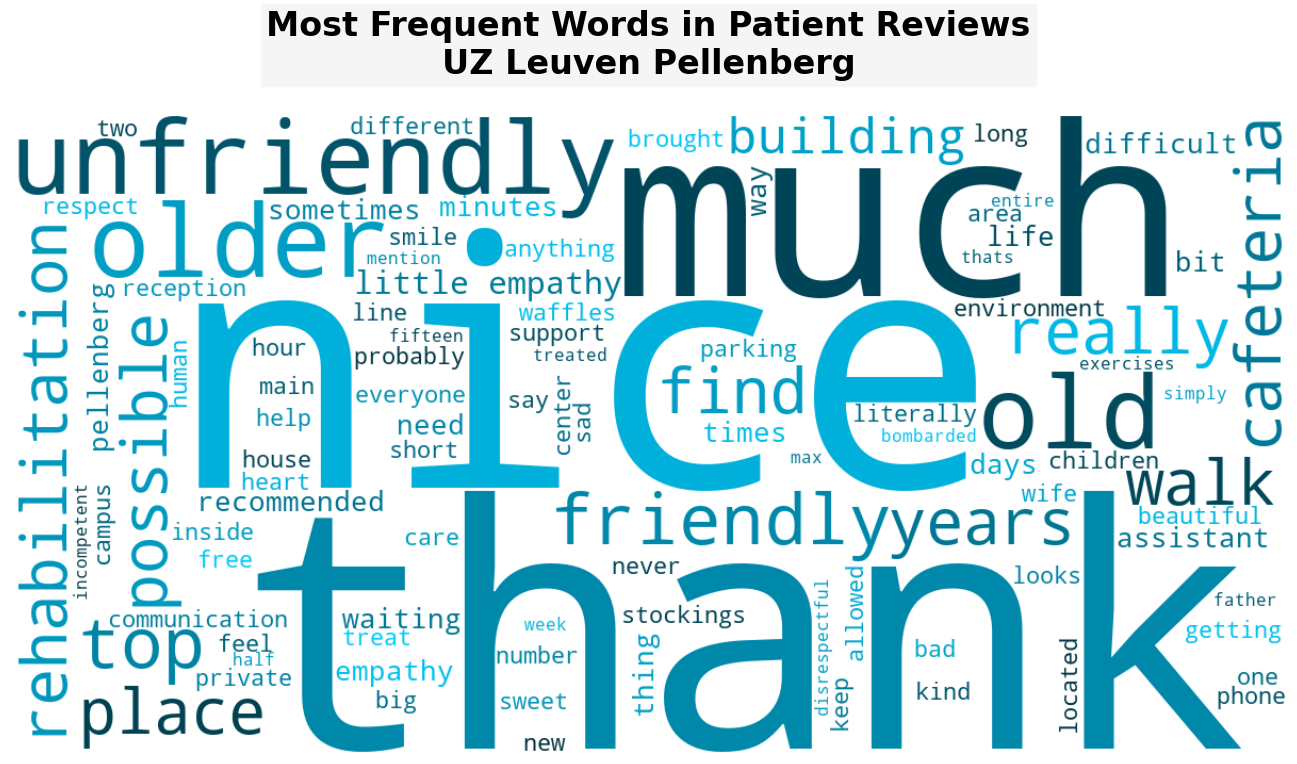

In [34]:
plot_wordcloud_by_hospital(df, "UZ Leuven Pellenberg")

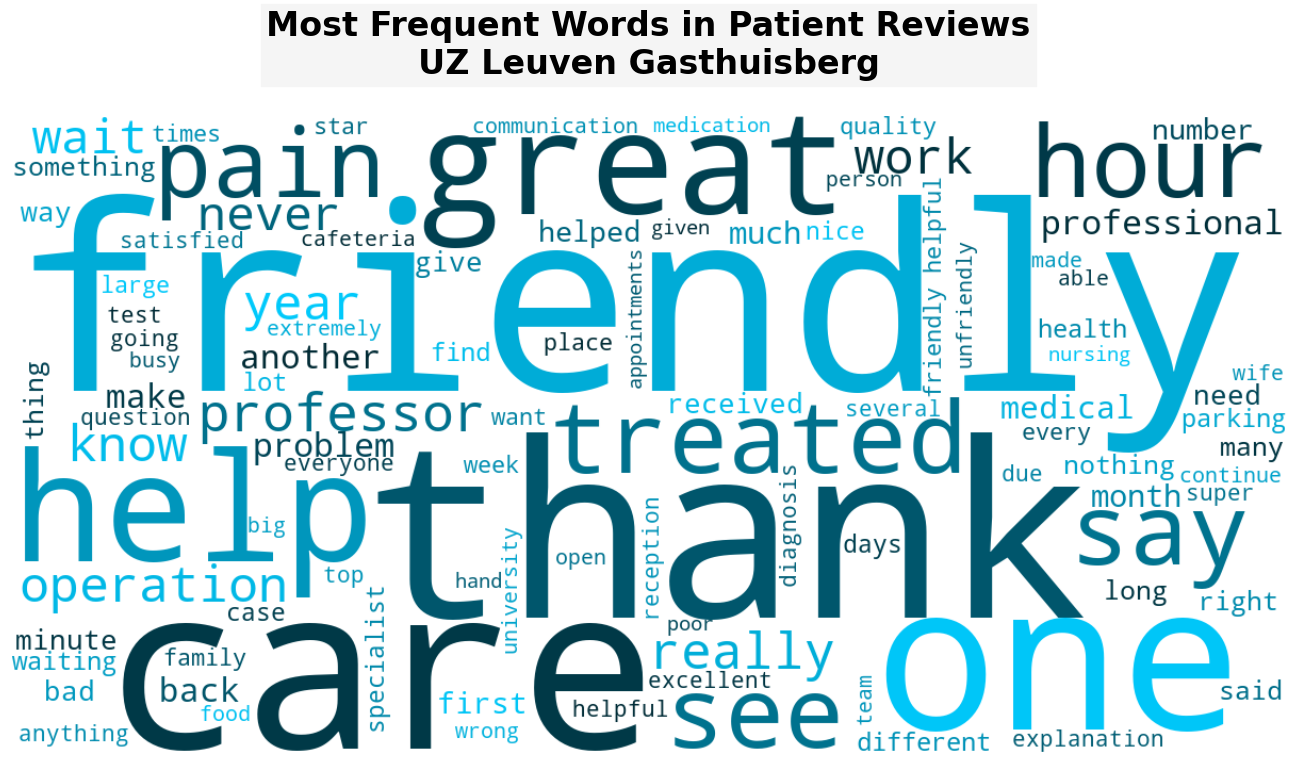

In [35]:
plot_wordcloud_by_hospital(df, "UZ Leuven Gasthuisberg")

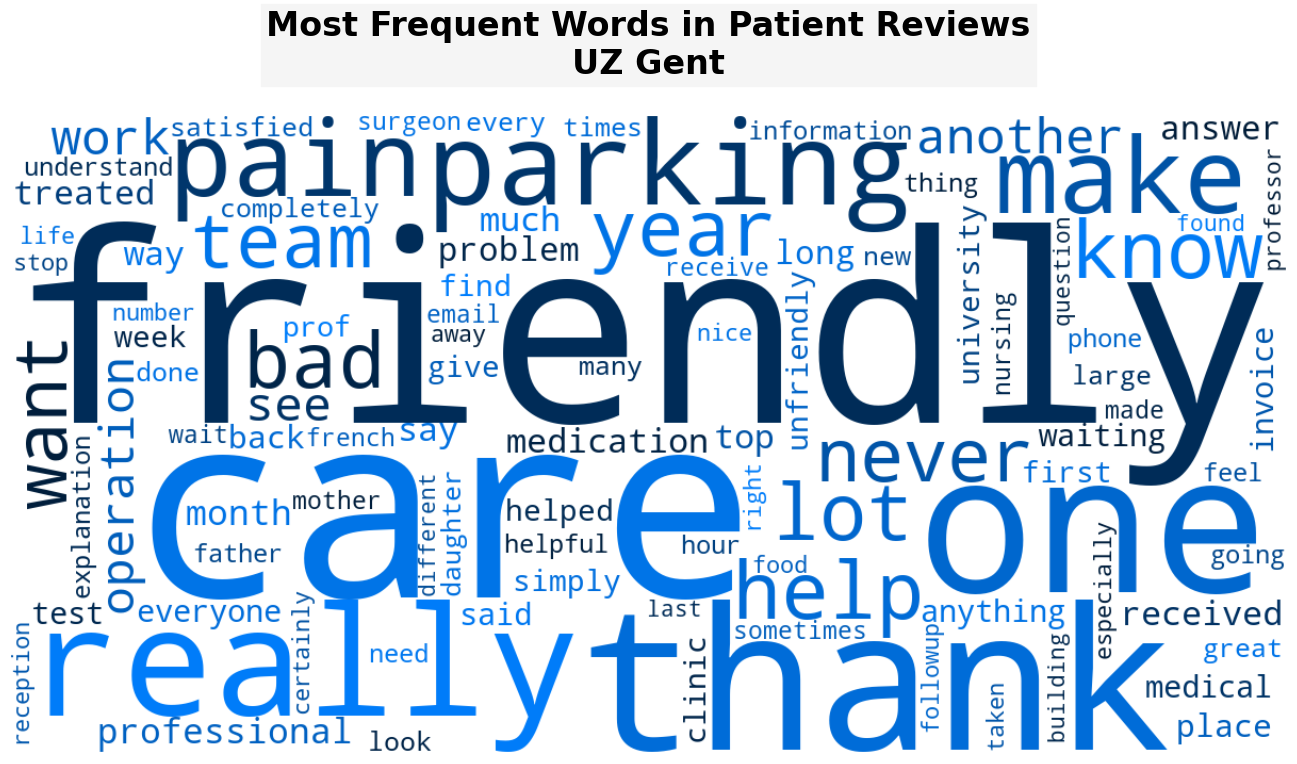

In [36]:
plot_wordcloud_by_hospital(df, "UZ Gent")

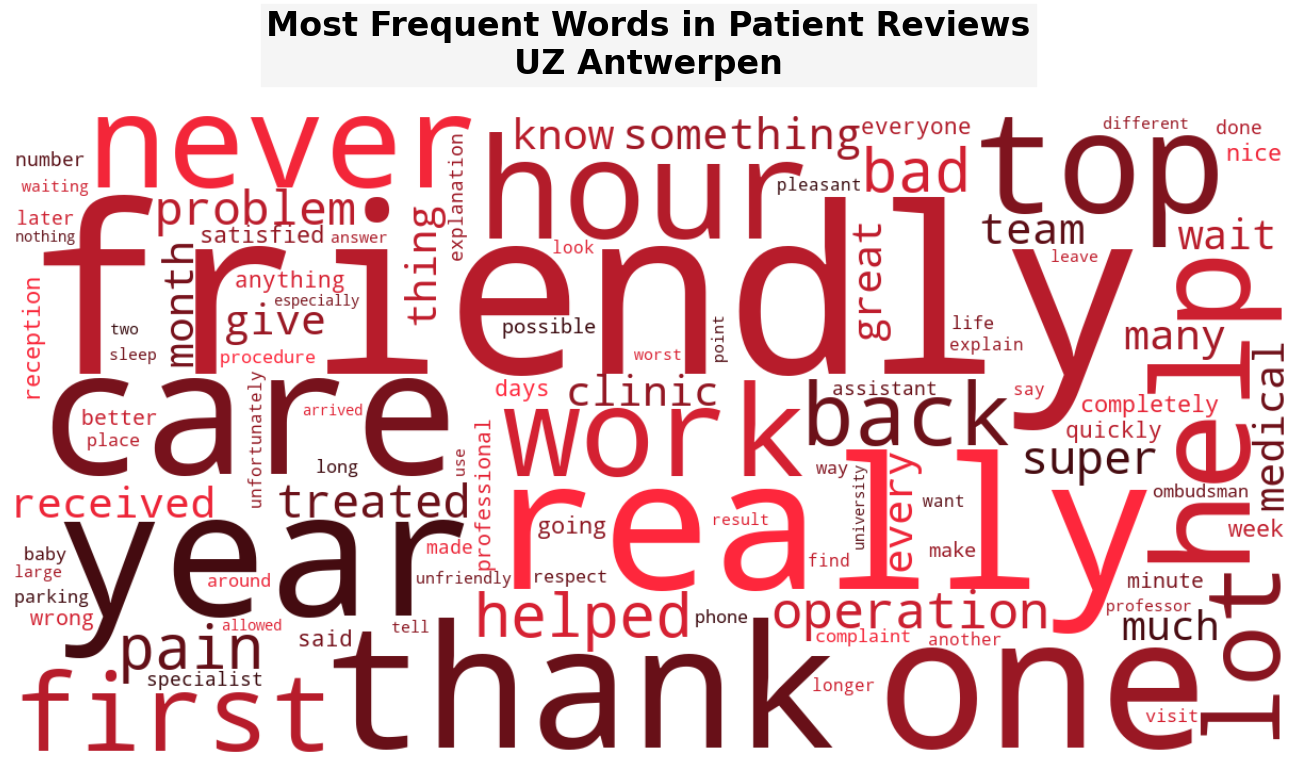

In [37]:
plot_wordcloud_by_hospital(df, "UZ Antwerpen")

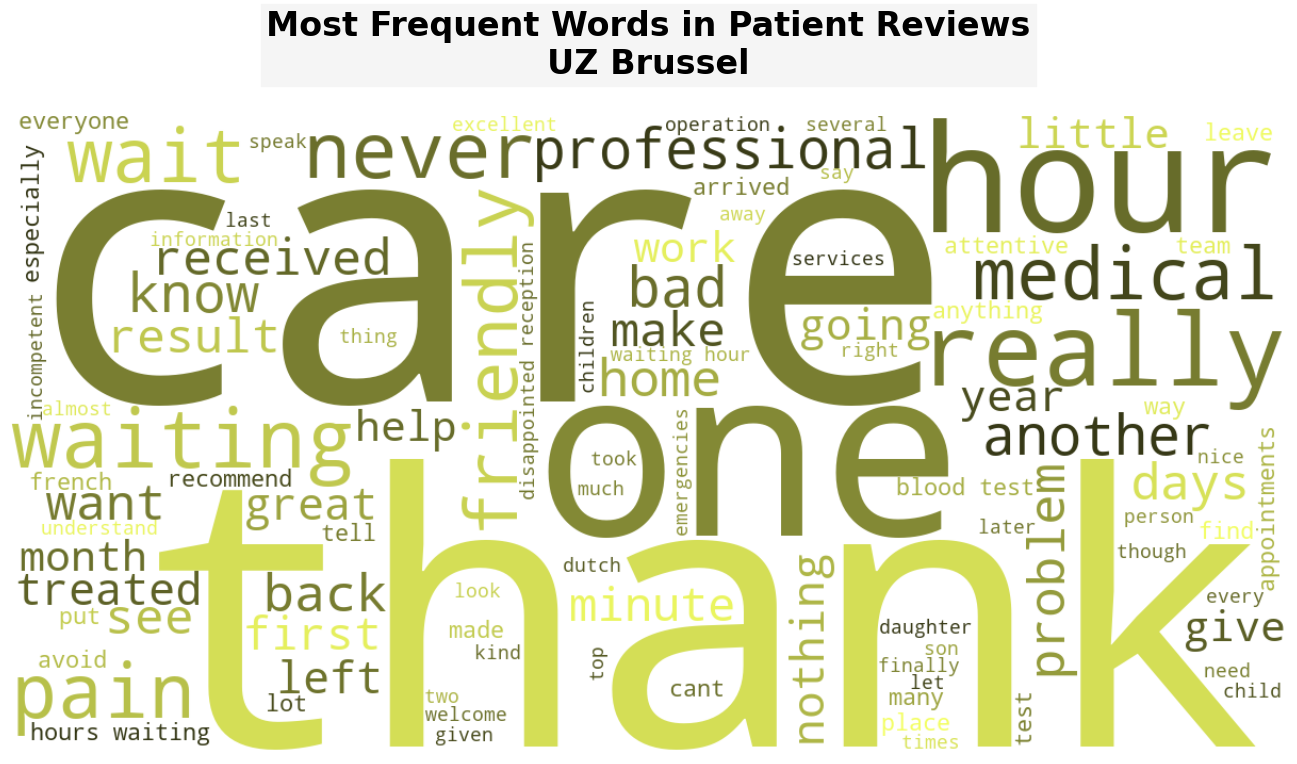

In [38]:
plot_wordcloud_by_hospital(df, "UZ Brussel")

## Topic Modeling LDA

In [82]:
def preprocess_texts(text_series):
    custom_stopwords_topic = set(sorted([
    'also', 'already', 'always', 'appointment', 'ask', 'asked', 'belgium', 'best', 'brussel', 
    'brussels', 'call', 'called', 'came', 'come', 'consultation', 'day', 'department', 'didnt', 
    'doctor', 'doctors', 'dont', 'dr', 'emergency', 'even', 'everything', 'experience', 
    'gasthuisberg', 'gent', 'ghent', 'go', 'good', 'heilig', 'hart', 'hospital', 'hospitals', 
    'leuven', 'nurse', 'nurses', 'patient', 'patients', 'people', 'room', 'service', 'staff', 
    'still', 'surgery', 'take', 'time', 'told', 'treatment', 'uz', 'uza', 'well', 'went', 'with', 
    'without', 'get', 'like', 'just', 'one', 'really', 'see', 'say', 'make', 'much', 'even', 'first', 
    'back', 'never', 'know', 'right', 'thing', 'things', 'many', 'now', 'lot', 'feel', 'felt', 
    'want', 'maybe', 'always', 'might', 'didnt', 'isnt', 'yes', 'oh', 'm', 've', 't', 'thats', 
    'youre', 'hes', 'im', 'dont', 'didnt'
    ]))
    stop_words = set(stopwords.words("english")).union(custom_stopwords_topic)

    tokenized = [
        [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stop_words]
        for text in text_series.dropna()
    ]
    return tokenized

In [83]:
def create_corpus_dictionary(tokenized_texts):
    dictionary = corpora.Dictionary(tokenized_texts)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_texts]
    return corpus, dictionary

In [84]:
def train_lda(corpus, dictionary, num_topics=4):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42,
        passes=10,
        alpha='auto',
        per_word_topics=True
    )
    return lda_model

In [85]:
soft_colors = [
    "#A6CEE3",  # soft blue
    "#B2DF8A",  # soft green
    "#FB9A99",  # soft red/pink
    "#FDBF6F",  # soft orange
    "#CAB2D6",  # soft purple
    "#FFFF99",  # soft yellow
    "#1F78B4",  # darker blue
    "#33A02C",  # darker green
]

def plot_topic_wordclouds(lda_model, num_topics, hospital_name):
    fig, axes = plt.subplots(1, num_topics, figsize=(5 * num_topics, 6))

    # In case there's only one topic
    if num_topics == 1:
        axes = [axes]

    for topic_num in range(num_topics):
        topic_words = dict(lda_model.show_topic(topic_num, topn=50))

        # Color function for single color per topic
        def topic_color_func(*args, **kwargs):
            return soft_colors[topic_num % len(soft_colors)]

        wc = WordCloud(
            width=600,
            height=600,
            background_color='white'
        ).generate_from_frequencies(topic_words)

        wc = wc.recolor(color_func=topic_color_func)

        ax = axes[topic_num]
        ax.imshow(wc, interpolation='bilinear')
        ax.axis("off")
        ax.set_title(f"Topic {topic_num + 1}", fontsize=16, fontweight='bold')

    plt.suptitle(hospital_name, fontsize=22, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

In [86]:
def perform_topic_modeling_for_hospital(df, hospital_name, num_topics=4):
    hospital_df = df[df["hospital"] == hospital_name]
    text_series = hospital_df["clean_content"]

    # Preprocess
    tokenized_texts = preprocess_texts(text_series)

    # Create corpus & dictionary
    corpus, dictionary = create_corpus_dictionary(tokenized_texts)

    # Train LDA
    lda_model = train_lda(corpus, dictionary, num_topics=num_topics)

    # Plot
    plot_topic_wordclouds(lda_model, num_topics, hospital_name)

    return lda_model

Generating topics for UZ Brussel...


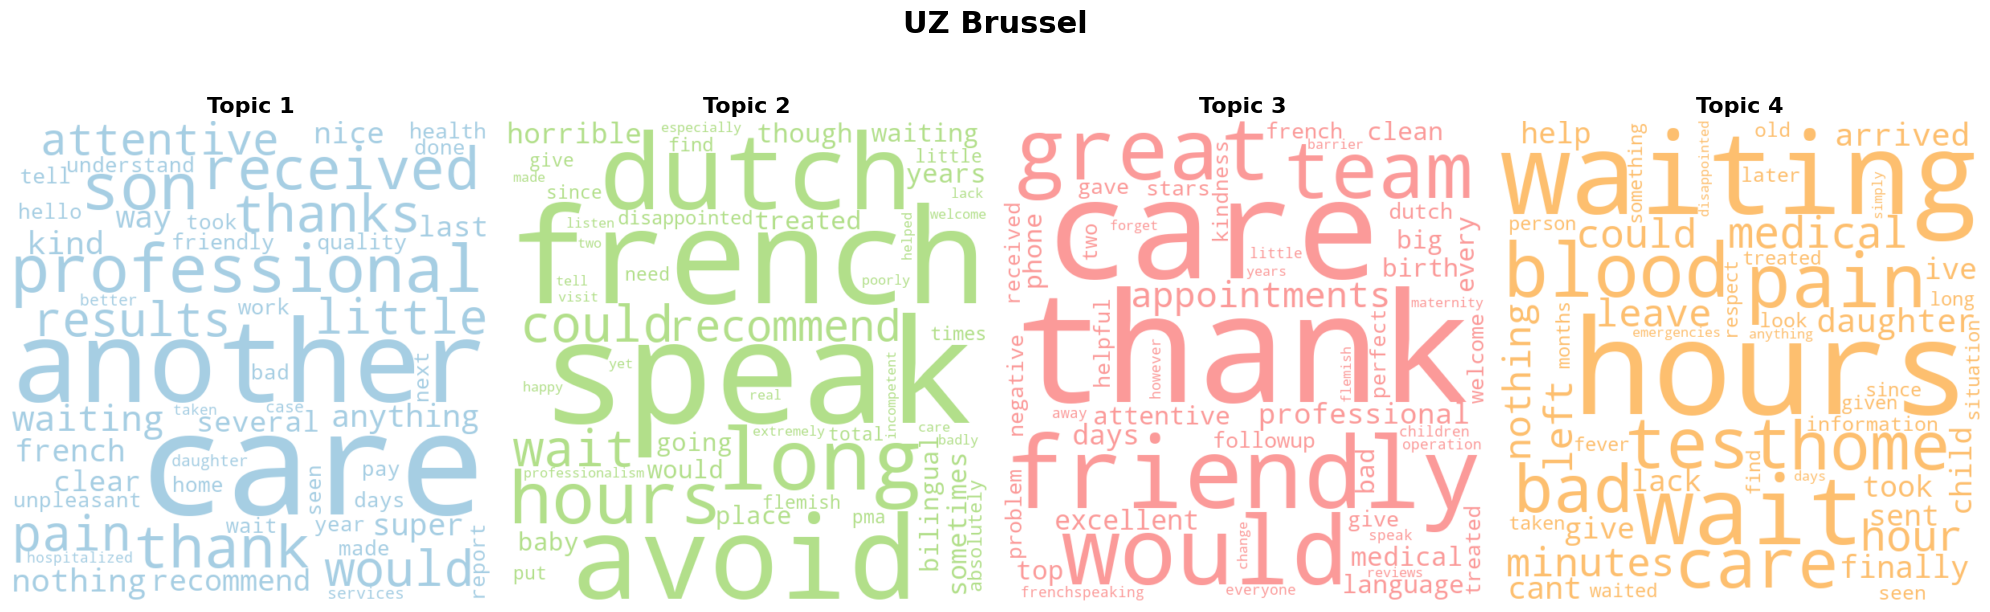

Generating topics for UZ Leuven Pellenberg...


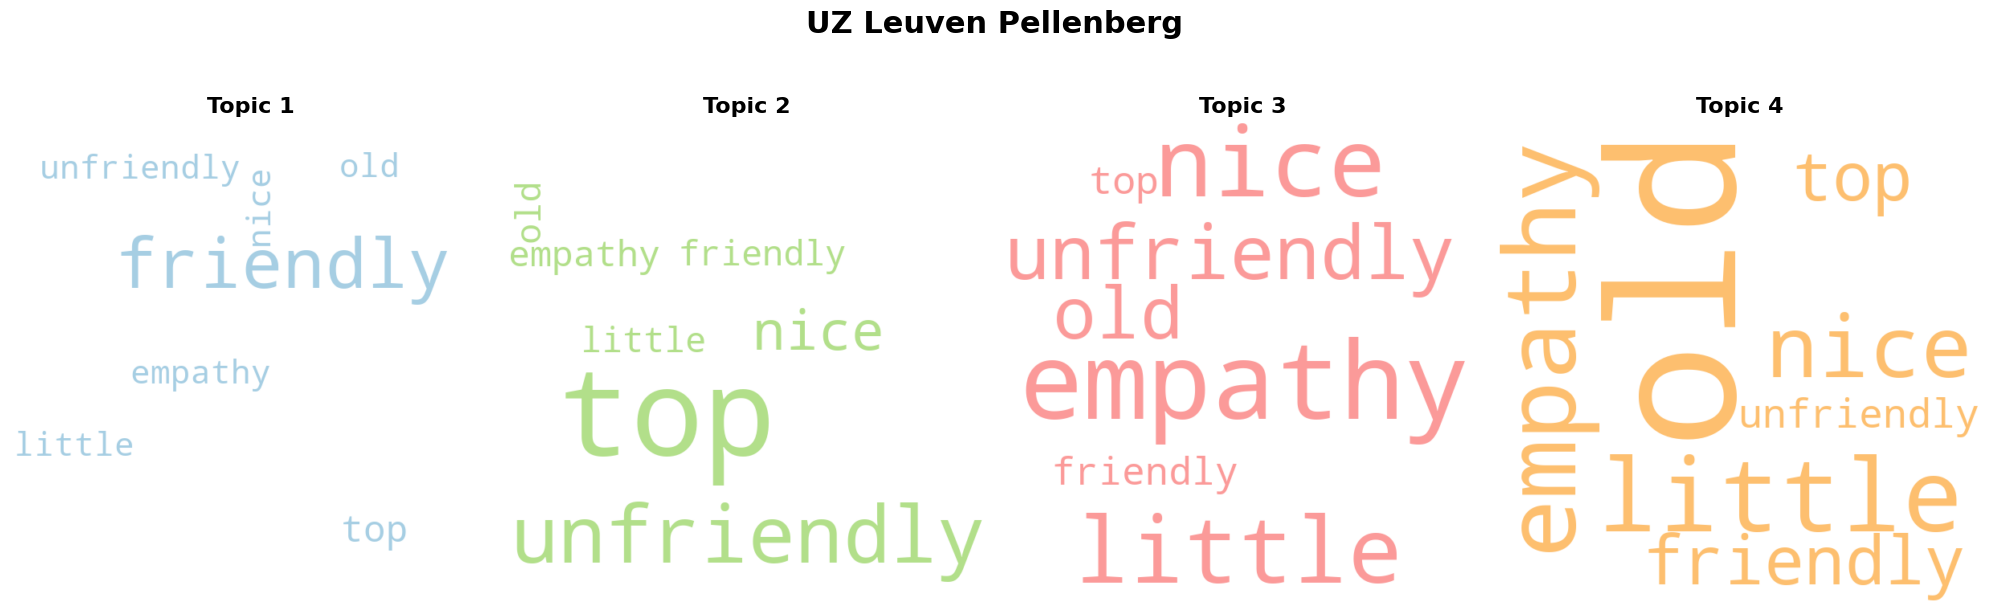

Generating topics for UZ Leuven Gasthuisberg...


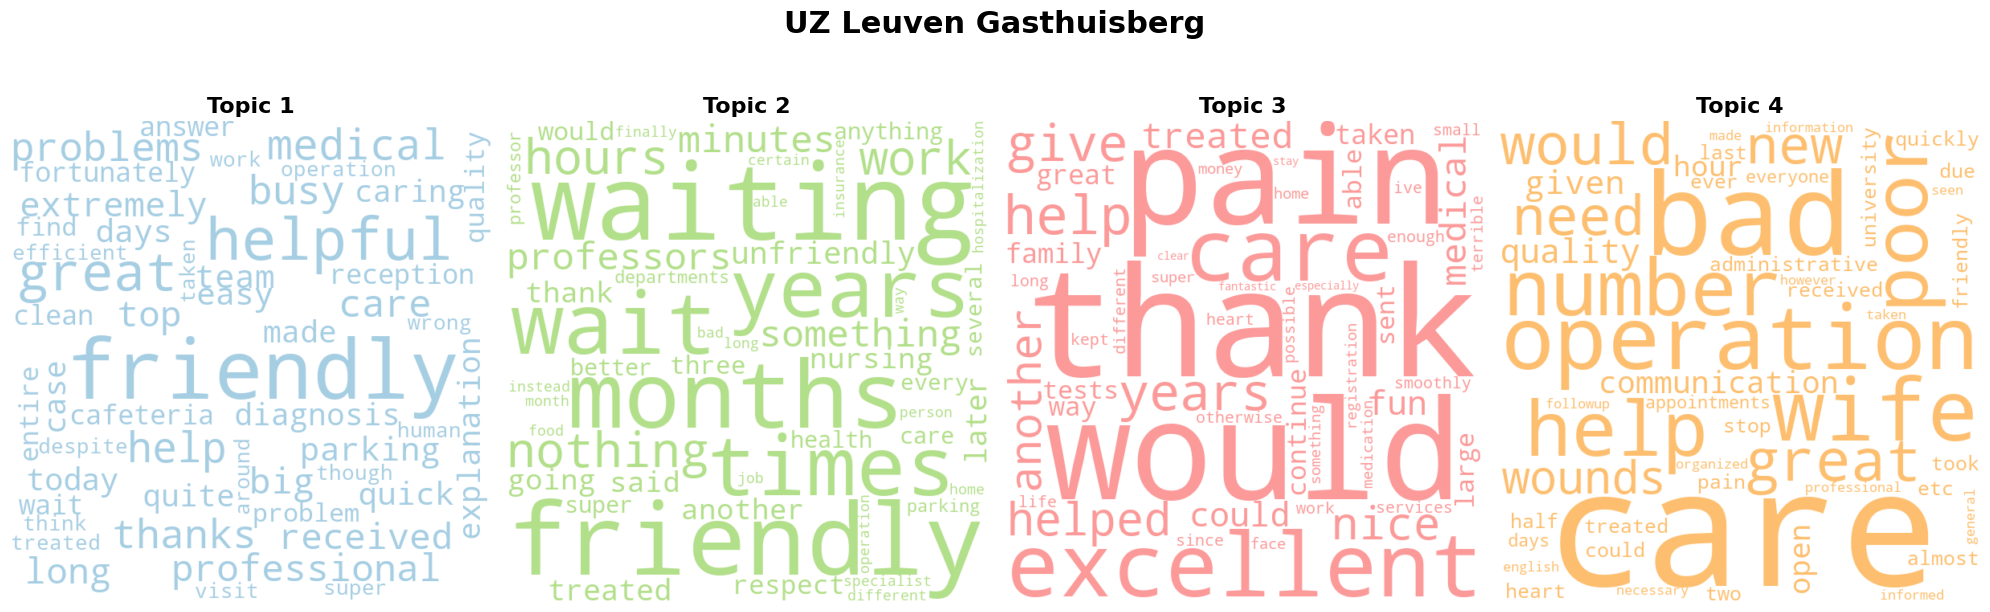

Generating topics for UZ Gent...


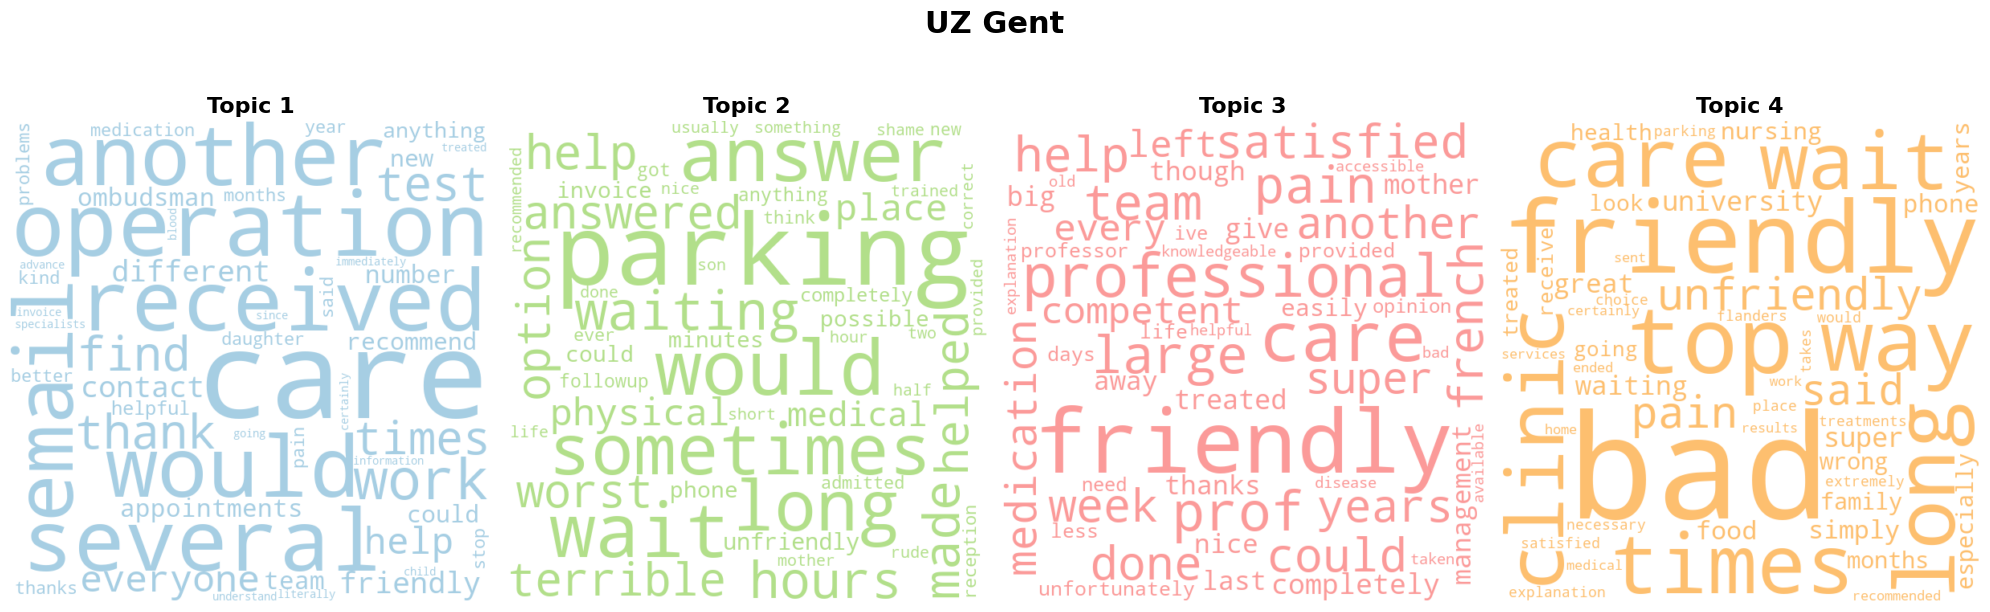

Generating topics for UZ Antwerpen...


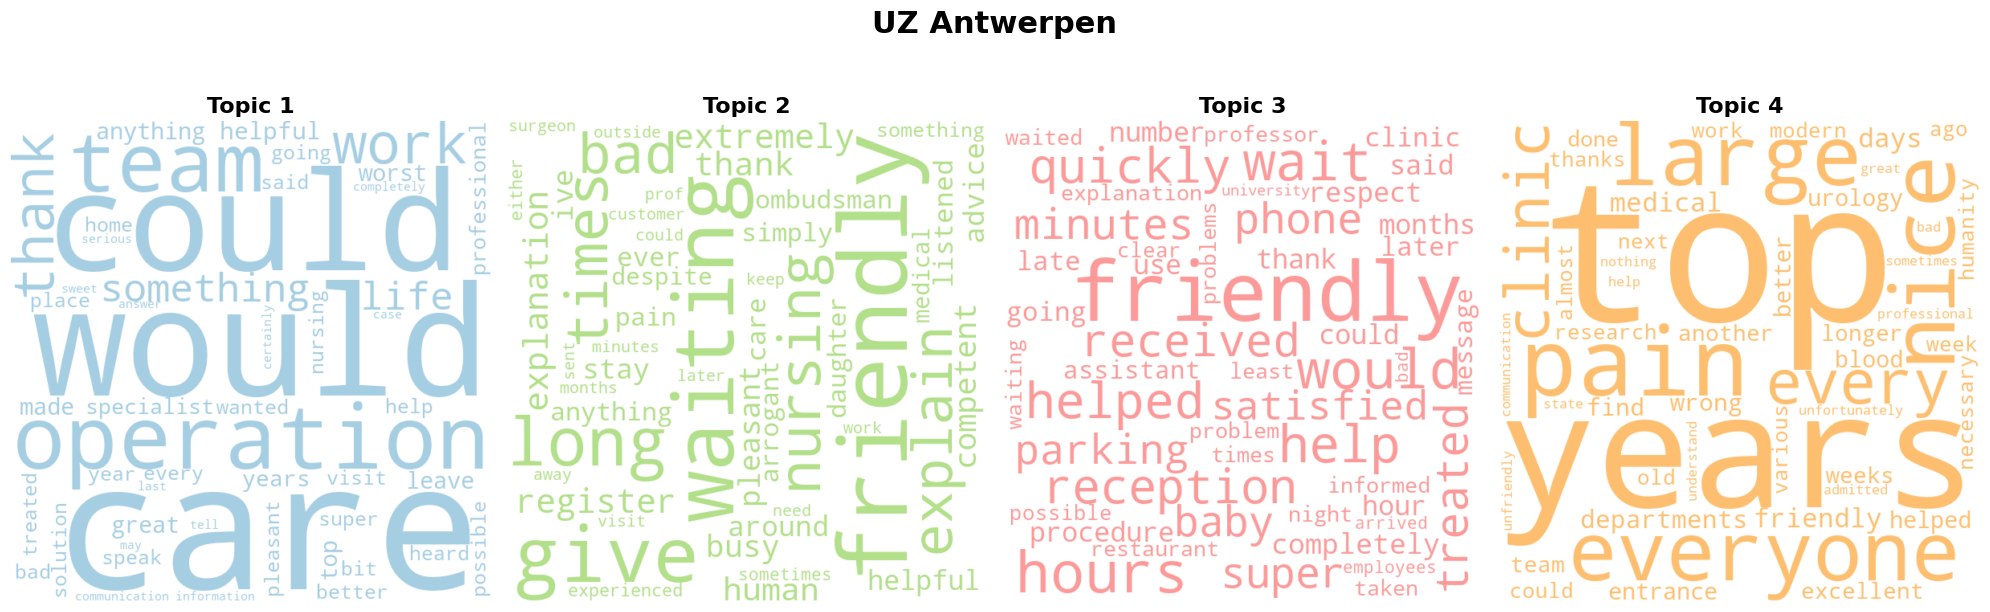

In [88]:
for hospital_name in df['hospital'].unique():

    print(f"Generating topics for {hospital_name}...")
    perform_topic_modeling_for_hospital(df, hospital_name, num_topics=4)

## Sentiment Analysis

### VADER

In [91]:
def reduce_elongation(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

def clean_text_sentiment(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = text.strip()
    text = text.lower()
    text = reduce_elongation(text)
    text = text.strip()
    return text

In [92]:
df["clean_for_sentiment"] = df["content"].apply(clean_text_sentiment)

In [93]:
df["clean_for_sentiment"]

0       i had an ivf consultation with a female prof. ...
1                    excellent hospital!! i recommend it.
2       friendly doctors and nurses. i don't really un...
3       i went to uz brussel in 2020 for egg cryoprese...
4       the emergency department is horrible. if there...
                              ...                        
1825                              good connection top uza
1826    thanks to the uza, we have already added 5 yea...
1827    incompetent nurses and an ombudsman service wh...
1828                  be pampered again by frank kine :-)
1829         you can take speculos for free and drink tea
Name: clean_for_sentiment, Length: 1830, dtype: object

In [94]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    if pd.isnull(text) or text.strip() == "":
        return 0, 0, 0, 0, "neutral"

    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        label = 'positive'
    elif compound <= -0.05:
        label = 'negative'
    else:
        label = 'neutral'
    return scores['pos'], scores['neu'], scores['neg'], compound, label

df[['vader_positive', 'vader_neutral', 'vader_negative', 'vader_compound', 'vader_sentiment']] = df['clean_for_sentiment'].apply(
    lambda x: pd.Series(get_vader_sentiment(x))
)

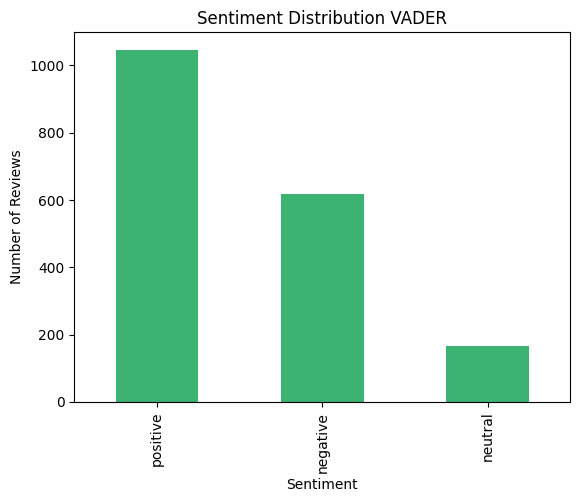

In [100]:
df['vader_sentiment'].value_counts().plot(kind='bar', color='mediumseagreen')
plt.title('Sentiment Distribution VADER')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

## Hugging Face

In [111]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
def get_distilbert_sentiment(text):
    if not text or text.strip() == "":
        return {"label": None, "score": None}
    result = sentiment_pipeline(text[:512])[0]  # truncate long text to 512 tokens
    return {"label": result["label"], "score": result["score"]}

df["distilbert_sentiment"] = df["clean_for_sentiment"].apply(get_distilbert_sentiment)

# If you want separate columns for label and score
df["distilbert_label"] = df["distilbert_sentiment"].apply(lambda x: x["label"])
df["distilbert_score"] = df["distilbert_sentiment"].apply(lambda x: x["score"])

Device set to use cpu


In [112]:
df

reviewer       date original_language  \
0                    m555 2025-07-01           English   
1             Joan Rangel 2025-07-01           Spanish   
2                  juvo92 2025-07-01             Dutch   
3                      LC 2025-07-01            French   
4        jutta henckaerts 2025-07-01             Dutch   
...                   ...        ...               ...   
1825      Line VAN DOOREN 2014-07-01             Dutch   
1826   Irene von Birgelen 2013-07-01             Dutch   
1827          Sofie L'Eau 2013-07-01             Dutch   
1828  Robertina Van Damme 2013-07-01             Dutch   
1829           Sonny Ardi 2012-07-01           English   

                                                content      hospital  \
0     I had an ivf consultation with a female Prof. ...    UZ Brussel   
1                  Excellent hospital!! I recommend it.    UZ Brussel   
2     Friendly doctors and nurses. I don't really un...    UZ Brussel   
3     I went to UZ Brussel in 2020 for egg cryoprese...    UZ Brussel   
4     The emergency department is horrible. If there...    UZ Brussel   
...                                                 ...           ...   
1825                            good connection top Uza  UZ Antwerpen   
1826  Thanks to the UZA, we have already added 5 yea...  UZ Antwerpen   
1827  Incompetent nurses and an ombudsman service wh...  UZ Antwerpen   
1828                Be pampered again by Frank kine :-)  UZ Antwerpen   
1829       You can take speculos for free and drink tea  UZ Antwerpen   

                                          clean_content  \
0     ivf female prof felt conclusion diagnosis reac...   
1                                   excellent recommend   
2         friendly really understand negative reactions   
3     egg cryopreservation ivf recommend facility ch...   
4     horrible nothing visible simply sent home wait...   
...                                                 ...   
1825                                     connection top   
1826               thanks added years together whoppers   
1827  incompetent ombudsman either one ever works on...   
1828                                pampered frank kine   
1829                            speculos free drink tea   

                                                 tokens  \
0     [ivf, female, prof, felt, conclusion, diagnosi...   
1                                [excellent, recommend]   
2     [friendly, really, understand, negative, react...   
3     [egg, cryopreservation, ivf, recommend, facili...   
4     [horrible, nothing, visible, simply, sent, hom...   
...                                                 ...   
1825                                  [connection, top]   
1826         [thanks, added, years, together, whoppers]   
1827  [incompetent, ombudsman, either, one, ever, wo...   
1828                            [pampered, frank, kine]   
1829                       [speculos, free, drink, tea]   

                                    clean_for_sentiment  vader_positive  \
0     i had an ivf consultation with a female prof. ...           0.040   
1                  excellent hospital!! i recommend it.           0.693   
2     friendly doctors and nurses. i don't really un...           0.189   
3     i went to uz brussel in 2020 for egg cryoprese...           0.045   
4     the emergency department is horrible. if there...           0.076   
...                                                 ...             ...   
1825                            good connection top uza           0.701   
1826  thanks to the uza, we have already added 5 yea...           0.195   
1827  incompetent nurses and an ombudsman service wh...           0.089   
1828                be pampered again by frank kine :-)           0.277   
1829       you can take speculos for free and drink tea           0.292   

      vader_neutral  vader_negative  vader_compound vader_sentiment  \
0             0.889           0.071         -0.7267  

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

def get_hf_sentiment(text):
    if pd.isnull(text) or text.strip() == "":
        return "neutral", 0.0

    result = sentiment_pipeline(text[:512])[0]
    return result['label'].lower(), result['score']

df[['hf_sentiment', 'hf_score']] = df['content'].apply(
    lambda x: pd.Series(get_hf_sentiment(x))
)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Device set to use cpu


In [102]:
df[['content', 'hf_sentiment', 'hf_score']].head()

content hf_sentiment  hf_score
0  I had an ivf consultation with a female Prof. ...     negative  0.999486
1               Excellent hospital!! I recommend it.     positive  0.999808
2  Friendly doctors and nurses. I don't really un...     negative  0.986611
3  I went to UZ Brussel in 2020 for egg cryoprese...     negative  0.999744
4  The emergency department is horrible. If there...     negative  0.995120

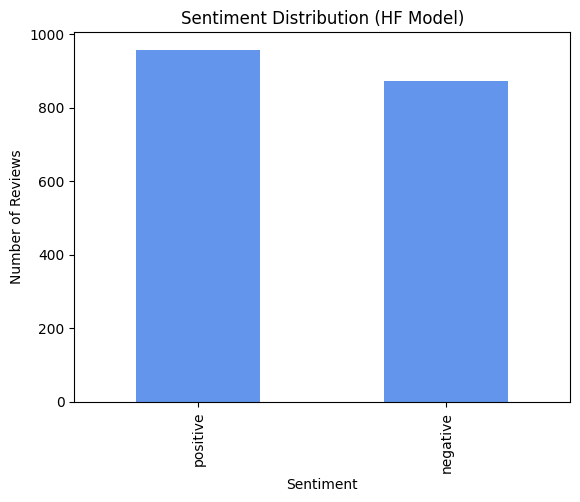

In [103]:
df['hf_sentiment'].value_counts().plot(kind='bar', color='cornflowerblue')
plt.title('Sentiment Distribution (HF Model)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

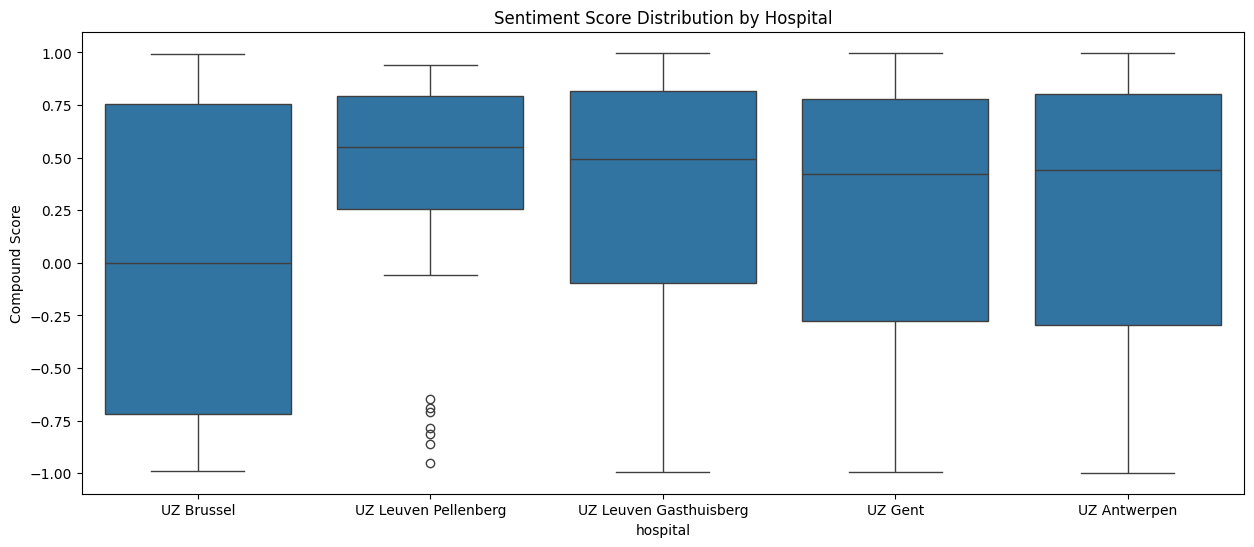

In [107]:
plt.figure(figsize=(15, 6))
sns.boxplot(x="hospital", y="vader_compound", data=df)
plt.title("Sentiment Score Distribution by Hospital")
plt.ylabel("Compound Score")
plt.show()

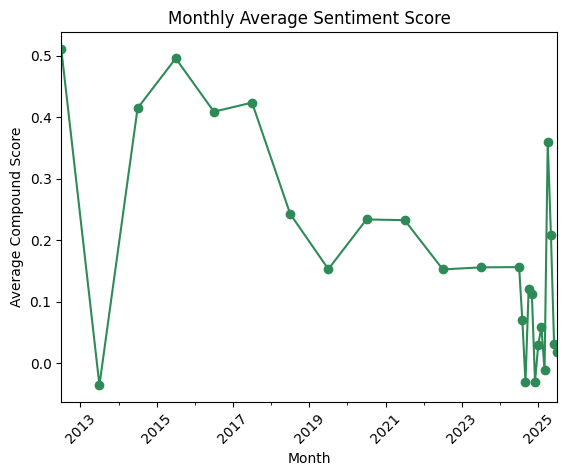

In [109]:
df["date"] = pd.to_datetime(df["date"])
df_grouped = df.groupby(df["date"].dt.to_period("M"))["vader_compound"].mean()

df_grouped.plot(marker="o", color="seagreen")
plt.title("Monthly Average Sentiment Score")
plt.ylabel("Average Compound Score")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.show()

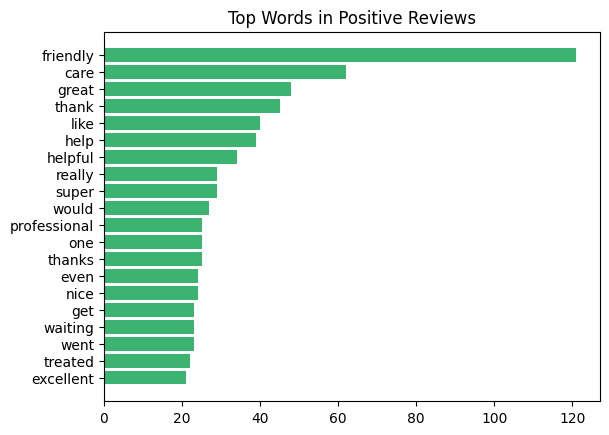

In [41]:
from collections import Counter

positive_words = df[df["sentiment"] == "positive"]["clean_content"].str.split().explode()
pos_counts = Counter(positive_words)
pos_common = pos_counts.most_common(20)

words, counts = zip(*pos_common)
plt.barh(words[::-1], counts[::-1], color="mediumseagreen")
plt.title("Top Words in Positive Reviews")
plt.show()

In [99]:
print("Example positive review:\n")
print(df[df["vader_compound"] > 0.9]["content"].iloc[3])
print("\nExample negative review:\n")
print(df[df["vader_compound"] < -0.5]["content"].iloc[3])

Example positive review:

Most efficient and professional hospital I have ever seen around Europe so far. I had a smaller routine surgery here as a day patient and it was - as hospital visits go - the best experience I ever had. Everyone was suoer-helpful, kind and highly professional, all procedures were on time and processing went like clockwork. Thanks to all the UZ staff who took such wonderful care of me.

Example negative review:

Injured in an accident, I went to the emergency room at this hospital, but they didn't take me seriously. It's true that the tent was there quickly, in less than an hour. But otherwise, I'm very disappointed with both the nurses and the doctor because they didn't examine me properly, and in the end, not even a "come in today" or "get well soon" message.
None of that!
Very disappointed with their behavior as people who work in the medical field!!!! My first and last time!
